#Predicting Academy Awards Success: A Web Scraping Project

In [86]:
import requests
from bs4 import BeautifulSoup
import lxml
import html5lib
import pandas as pd
import numpy as np
import re
import pickle

What makes an Academy Award-winning movie? What characteristics do winners and nominess share? Is there a way to predict that a given movie will be nominated for an award (or multiple awards) based on a number of characteristics? Why am I asking so many rhetorical questions? 

Lets take a look at some data from the past 20 years of film. Which characteristics do these moveies share? Are they acclaimed, high-grossing, in a particular runtime range, or do they share some other common features? Broadly, we'll examine how well we can predict success in the Academy's eyes, given a set of these characteristics. 

Broadly, the three types of data we have about films are:

- Financial Info: Budget, Earnings, Etc.
- Ratings Info: User Reviews and Metacritic Scores
- Academy Awards Info: Nominations and Wins

With enough of this data, we should be able to draw some conclusions about movies that are nominated and awarded in the Academy Awards.

##Part 1: Mining the Data

In [6]:
year_range = [1985+i for i in range(30)]

In [7]:
def get_nominees(year):
    '''Scrape IMDB Awards pages for titles of winning movies'''
    url = 'http://www.imdb.com/event/ev0000003/' + str(year) # base url structure for IMDB Awards page per year
    page = requests.get(url).text
    soup = BeautifulSoup(page)
    nominees = {}
    for i in range(len(soup.find_all(class_='alt'))):
        try:
            title = soup.find_all(class_='alt')[i].find_all('a')[1].text
            mov_url =soup.find_all(class_='alt')[i].find_all('a', href=True)[1]['href']
            nominees[title] = mov_url 
        except:
            pass
    return nominees

In [8]:
titles = {}
for year in year_range:
    titles.update(get_nominees(year))

In [10]:
def clean_dict(inp):
    '''Cleans input dictionary of any actors that get mixed in with nominated movies'''
    dictionary = inp
    for i in dictionary.keys():
        if dictionary[i].find('/name/') != -1:
            dictionary.pop(i)
    return dictionary
titles = clean_dict(titles)

I'm a big proponent of using Pandas for storing this kind of data, so lets set up a dataframe to store everything here (maybe later it'll be a good idea to put all of this in SQLite3 for easy recovery):

In [11]:
movie_df = pd.DataFrame(index=titles.keys(), columns=['IMDBurl', 'AwardsWon', 'AwardsNominated', 'MetaRating', 'UserRating', 
                                                      'Runtime', 'Year','BoxOfficeGross', 'OpeningWeekend', 'Budget'])
movie_df = movie_df.fillna(0) # with 0s rather than NaNs
#movie_df['Title'] = titles
for i in movie_df.index:
    movie_df.loc[i, 'IMDBurl'] = titles[i]

Now, lets get the key data for these movies:

In [12]:
def get_imdb_data(movie_name):
    #find good way to soup this data from IMDB
    url = 'http://www.imdb.com' + str(movie_df.loc[movie_name, 'IMDBurl'])
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html5lib')
    
    try: # to get Ratings data
        movie_df.loc[movie_name, 'UserRating'] = float(soup.find(itemprop="ratingValue").text)/10
        movie_df.loc[movie_name, 'MetaRating'] = float(soup.find(class_="star-box-details").find_all('a')[1].text[:3])/100
    except:
        pass
    
    try: # to get Runtime, Year, Earnings
        movie_df.loc[movie_name, 'Runtime'] = int(soup.find(itemprop="duration").text.split(' ')[16])
        movie_df.loc[movie_name, 'Year'] = soup.find(class_="nobr").text.replace('(', '').replace(')', '')
        movie_df.loc[movie_name, 'BoxOfficeGross'] = money_to_int(soup.find_all(class_='txt-block')[14].text)
        movie_df.loc[movie_name, 'OpeningWeekend'] = money_to_int(soup.find_all(class_='txt-block')[13].text)
    except:
        pass
    
    try: # to get Awards & Budget data
        if soup.find_all(itemprop="awards")[0].find('b').text.split(' ')[0] == 'Won':
            movie_df.loc[movie_name, 'AwardsWon'] = \
                        int(soup.find_all(itemprop="awards")[0].find('b').text.split(' ')[1])
        else:
            movie_df.loc[movie_name, 'AwardsNominated'] = \
                        int(soup.find_all(itemprop="awards")[0].find('b').text.split(' ')[2])
        movie_df.loc[movie_name, 'Budget'] = money_to_int(soup.find_all(class_='txt-block')[12].text)*100000
    except:
        pass

In [24]:
for movie in movie_df.index:
    #print(movie)
    get_imdb_data(movie)

In [25]:
movie_df['Budget'] = [int(movie_df['Budget'][i]) for i in movie_df.index]

In [26]:
# pickle it up
with open('movies.pkl', 'w') as picklefile:
    pickle.dump(movie_df, picklefile)

helper functions:

In [27]:
import dateutil.parser

def to_date(datestring):
    date = dateutil.parser.parse(datestring).year
    return date

def money_to_int(moneystring):
    moneystring = re.sub("[^0-9]", "", moneystring)[:-6]
    return int(moneystring)

#Part 2: Investigation, Analysis & Cleaning

If we take a look at the DataFrame object printed above, we see some broad facts about the data. First, due to the way the data is presented on IMDB, we have two classes of objects, those that have won academy awards, and those that have been nominated but have failed to win. Another unfortunate reality is that not all IMDB pages are the same: some lack information about how much money they've earned, their budget, or their critical reception. This presents some choices:

- __Partitioning the Data__: If we split the data into nominees and winners, we may end up with a better understanding of what separates the great movies from the simply good ones. On the other hand - considering them all as one class may have its benefits -- after all, these moves are deemed by the Academy to be the cream of the crop, so they must all share some sort of characteristics.


- __Dealing with Null Values__: If we remove movies for which we don't have budget and earnings data, we'll have a much easier time studying trends - a heap of zeros will mess any analysis up, especially because it's simply **untrue** that any of these movies were created without a budget or did not earn any money. On the other hand, it's likely that only more well known (and generally financially successful) movies release information about their finances - so removing movies without these data might skew our results.

As such, I propose that we consider several classes of movies, and values associated with them:

- __Award Winners with Complete Data:__ these movies have won at least one award and have complete entries on IMDB for their financial and ratings profiles. If we can come up with statistics that predict a movie will an award (or factors that cause some movies to win *lots* of awards) then we have a key component in hand for this project. In particular, we'll see if higher budget, higher earnings movies succeed in the Academy Awards or if lower budget movies tend to see more praise.


- __Award Nominees and Winners with Complete Data:__ for this category, we're interested in looking at all how variables like finance and ratings influence appearance in the Award Show. Sometimes, being nominated is good enough. After all, some of my favorite films of the past 20 years (like Fight Club) failed to win any awards, presumably because people who care about film are total idiots. Another part of this project is to predict if a given movie will get a nod from the academy, given a full set of stats about it.


We'll also consider some questions about all of these movies, particularly related to their IMDB User Ratings and Metacritic Ratings:

- How similarly do laypeople (IMDB reviewers) and the general critical population (Metacritics) receive movies? 


- Does critical success with laypeople correlate to success with the Academy? Does Metacritic Score correlate with award-winning? Do more well-liked movies win frequently, or is the Academy a harsher judge of cinematic success than ordinary people?

In [4]:
with open("movies.pkl", 'r') as picklefile: 
    df = pickle.load(picklefile)
df

,IMDBurl,AwardsWon,AwardsNominated,MetaRating,UserRating,Runtime,Year,BoxOfficeGross,OpeningWeekend,Budget
Complaints of a Dutiful Daughter,/title/tt0109465/,0,1,0.03,0.74,44,1994,0,0,0
Crimson Tide,/title/tt0112740/,0,3,0.66,0.73,116,1995,0,0,290292900000
The Crime of Father Amaro,/title/tt0313196/,0,1,0.60,0.68,118,2002,570961,496290,100000
"Fine Food, Fine Pastries, Open 6 to 9",/title/tt0097356/,0,1,0.00,0.73,29,1989,0,0,0
Tango,/title/tt0120274/,0,1,0.40,0.71,115,1998,0,0,7831500000
Creature Comforts,/title/tt0099317/,1,0,0.20,0.78,5,1989,0,0,0
Before Midnight,/title/tt2209418/,0,1,0.94,0.80,109,2013,0,0,81145000000
A Grand Day Out,/title/tt0104361/,0,1,0.40,0.78,23,1989,0,0,0
Doubt,/title/tt0918927/,0,5,0.68,0.75,104,2008,3342255,507226,2000000
Coming to America,/title/tt0094898/,0,2,0.48,0.69,116,1988,0,0,12800000


Lets clean up this data a bit. We'll pair off movies with erroneously small Metacritic ratings (the 0.03 isn't actually on the website, it's a result of bad parsing when this field isn't present). You'll notice that every movie has a user rating, so we don't need to worry about that. We'll also subdivide this group into a group that has ratings and good financial info.

In [5]:
rated = df[df['MetaRating'] > 0.10]

In [6]:
financed = rated[rated['BoxOfficeGross'] > 10000] # anything less than 10,000 is a: sad, b: probably a parse error

Now that we have a list of movies with complete data, lets find a way to deal with this nominated/winner problem. As described above, IMDB only gives us data for one or the other: so if you win it shows (only) your wins and if you don't it just shows your nominations.

We'll subdivide the frames into two smaller subsets (Winners and Nominees) and also merge the two scores into a single score. At the risk of introducing some "magic" into the equation, we'll say that winning one Oscar is worth being nominated for 5. Of course, that's not an actual measurement (after all, in order to win, you must be nominated), but rather a way of quantizing how much an Oscar is worth related to a nomination. I'd rather have one Oscar than 5 nominations, but if you offered me 6 nominations, I'd probably take them based on how unlikely it would to receive that many nominations and come home empty handed.

In [7]:
winners = financed[financed['AwardsWon'] > 0]
nominees = financed[financed['AwardsNominated'] > 0]
total = financed
total['AwardRank'] = 5*total['AwardsWon'] + total['AwardsNominated']

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#Part 3: Predicting Success in the Academy Awards

In [115]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#### Correlation between Ranking Factors
First, lets do a basic investigation: are Metacritic ratings and User ratings on IMDB correlated? Since Metacritic aggregates reviews from critics and web users, we'd expect that movies with a higher ranking on one would rank higher on the other. There should at least some basic evidence for correlation between these scores. We use the combined `total` Data Frame for the largest functional dataset:

In [116]:
y = total['MetaRating'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
metarating = total['UserRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Slope': metarating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     102.7
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           7.63e-21
Time:                        16:49:49   Log-Likelihood:                 181.40
No. Observations:                 290   AIC:                            -358.8
Df Residuals:                     288   BIC:                            -351.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1108      0.082     -1.350      0.178        -0.272     0.051
Slope          1.1096      0.109     10.135      0.000         0.894     1.325
==============================================================================
Omnibus:                       82.024   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.323
Skew:                          -1.231   Prob(JB):                     3.61e-56
Kurtosis:                       6.881   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

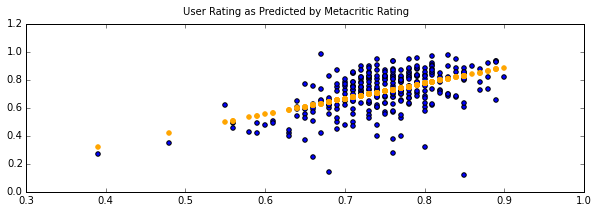

In [117]:
%matplotlib inline
plt.figure(figsize=(10,3)).suptitle('User Rating as Predicted by Metacritic Rating', fontsize='10')
plt.scatter(metarating, y)
plt.scatter(metarating, results.predict(X), color='orange')

##3.1: Correlation between Ratings and Award Rank 
As described above, I decided it was a good idea to come up with some kind of summary statistic quanitifying the value of nominations vs. actual awards. Lets see if this number is correlated in some way with user perception:

In [118]:
def MSE(yhat, y):
    return sum([(yhat[i] - y[i])**2 for i in range(len(y))])/len(y)

Summary of findings:

- *Linear Model,* $y = \beta_0 + \beta_1 X_1 + \beta_2 X_2$ :
   
   $R^{2}=0.14$
   
   $AIC=1942$
   
   $BIC=1953$
   
   $MSE = 56.106$



- *Multiplicative Exponential Model,* $y = e^{\beta_0 + \beta_1 X_1+ \beta_2 X_2}$:
   
   $R^{2} =0.2$
   
   $AIC=755$
   
   $BIC=766$
   
   $MSE = 0.834 $
   
   
- *Additive Exponential Model,* $y = \beta_0 + \beta_1 e^{X_1} + \beta_2 e^{X_2}$:
   
   $R^{2} =0.154$
   
   $AIC=1938$
   
   $BIC=1949$
   
   $MSE = 55.273$
   
Interestingly, the multiplicative model performs the best with regards to $MSE$ and $AIC/BIC$. By contrast, a simple additive exponential model did poorly.

In [119]:
y = total['AwardRank'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = total['UserRating'].as_matrix().tolist()
metarating = total['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     24.76
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           1.20e-10
Time:                        16:49:50   Log-Likelihood:                -997.22
No. Observations:                 290   AIC:                             2000.
Df Residuals:                     287   BIC:                             2011.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -21.3885      4.801     -4.455      0.000       -30.837   -11.940
Meta-Slope    12.1657      3.436      3.540      0.000         5.402    18.930
User-Slope    25.3383      7.437      3.407      0.001        10.700    39.977
==============================================================================
Omnibus:                      206.402   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2041.679
Skew:                           2.902   Prob(JB):                         0.00
Kurtosis:                      14.631   Cond. No.                         28.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

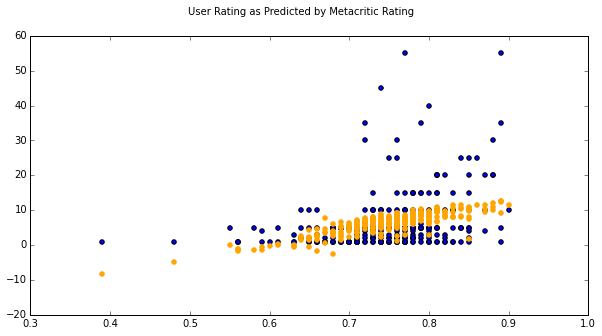

In [120]:
%matplotlib inline
plt.figure(figsize=(10,5)).suptitle('User Rating as Predicted by Metacritic Rating', fontsize='10')
plt.scatter(userrating, y)
plt.scatter(userrating, results.predict(X), color='orange')

As you can see, the correlation here is not great. The data appear to follow a more exponential distribution... What if we adjusted the model to fit an equation of the form:

This can be approached in two ways:
- Multiplicative Exponential: $y = e^{\beta_0 + \beta_1 X_1+ \beta_2 X_2}$
- Additive Exponential: $y = \beta_0 + \beta_1 e^{X_1} + \beta_2 e^{X_2}$

Lets try both and see if we can come up with a good model!

###3.1.1: Regression analysis on a Multiplicative Exponential Model

In [121]:
y = total['AwardRank'].as_matrix().tolist()
y = np.log(y)
x1 = [1 for _ in y] # constant
userrating = total['UserRating'].as_matrix().tolist()
metarating = total['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     35.46
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           1.73e-14
Time:                        16:49:51   Log-Likelihood:                -385.10
No. Observations:                 290   AIC:                             776.2
Df Residuals:                     287   BIC:                             787.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.5863      0.582     -4.447      0.000        -3.731    -1.442
Meta-Slope     1.9095      0.416      4.587      0.000         1.090     2.729
User-Slope     3.3447      0.901      3.712      0.000         1.571     5.118
==============================================================================
Omnibus:                        6.630   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                4.333
Skew:                           0.134   Prob(JB):                        0.115
Kurtosis:                       2.465   Cond. No.                         28.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MSE for Multiplicative Exponential Model:   0.833575122769


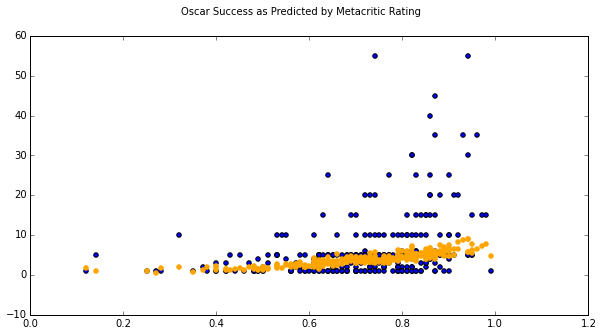

In [122]:
%matplotlib inline
plt.figure(figsize=(10,5)).suptitle('Oscar Success as Predicted by Metacritic Rating', fontsize='10')
plt.scatter(metarating, np.exp(y))
plt.scatter(metarating, np.exp(results.predict(X)), color='orange')

print('MSE for Multiplicative Exponential Model:   ' + str(MSE(results.predict(X), y)))

So we see that a multiplicative exponential model is actually decent here, although it still fails to account for a large amount of effect in the data. Maybe we can append it to build an even better model. However, such an analysis would branch into non-linear analysis, which is beyond the scope of this project.

###3.1.2: Regression analysis on an Additive Exponential Model

In [123]:
y = total['AwardRank'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = np.exp(total['UserRating'].as_matrix().tolist())
metarating = np.exp(total['MetaRating'].as_matrix().tolist())
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     27.57
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           1.11e-11
Time:                        16:49:51   Log-Likelihood:                -994.82
No. Observations:                 290   AIC:                             1996.
Df Residuals:                     287   BIC:                             2007.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -34.0268      6.512     -5.225      0.000       -46.845   -21.209
Meta-Slope     6.8130      1.752      3.888      0.000         3.364    10.262
User-Slope    12.3752      3.568      3.468      0.001         5.352    19.398
==============================================================================
Omnibus:                      205.118   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2038.001
Skew:                           2.874   Prob(JB):                         0.00
Kurtosis:                      14.646   Cond. No.                         51.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MSE for Additive Exponential Model:   55.8644350822


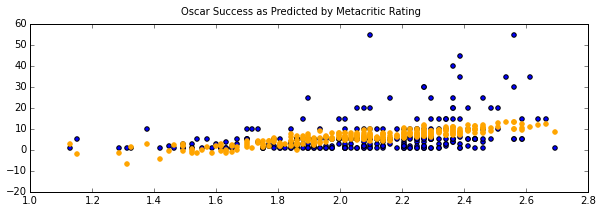

In [124]:
%matplotlib inline
plt.figure(figsize=(10,3)).suptitle('Oscar Success as Predicted by Metacritic Rating', fontsize='10')
plt.scatter(metarating, y)
plt.scatter(metarating, results.predict(X), color='orange')
print('MSE for Additive Exponential Model:   ' + str(MSE(results.predict(X), y)))

Thus we conclude that the additive exponetial model is not a great predictor of success, despite our initial hope that it would be.

## 3.2: Predicting Winner Success

Lets repeat the above study just looking at winners: are user and critic ratings a predictor for Academy Award wins? Do movies with higher ratings see a greater amount of wins?

In [125]:
y = winners['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = winners['UserRating'].as_matrix().tolist()
metarating = winners['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
#results.summary()

MSE for Simple Linear Model:   2.11696157122


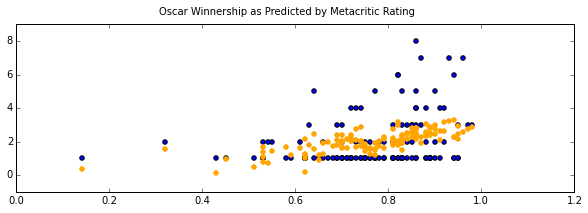

In [126]:
%matplotlib inline
plt.figure(figsize=(10,3)).suptitle('Oscar Winnership as Predicted by Metacritic Rating', fontsize='10')
plt.scatter(metarating,y )
plt.scatter(metarating, results.predict(X), color='orange')

print('MSE for Simple Linear Model:   ' + str(MSE(results.predict(X), y)))

### 3.2.1: Multiplicative Exponential Model for Oscar Wins

With a relatively poor $R^{2}$, we have a lot of variance still going unexplained by the model. Again, we lee that maybe an exponential function would be good for modeling the data: the $y$ values don't go below zero and increase greatly (for some movies) as $x$ increases. Keep in mind that this is just a slice of a picture, the model is a multivariate regression based on user and metacritic ratings.

In [127]:
y = winners['AwardsWon'].as_matrix().tolist()
y = np.log(y)
x1 = [1 for _ in y] # constant
userrating = winners['UserRating'].as_matrix().tolist()
metarating = winners['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     13.91
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           3.52e-06
Time:                        16:49:52   Log-Likelihood:                -108.49
No. Observations:                 128   AIC:                             223.0
Df Residuals:                     125   BIC:                             231.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.5599      0.597     -4.287      0.000        -3.742    -1.378
Meta-Slope     0.4593      0.432      1.063      0.290        -0.396     1.315
User-Slope     3.5287      0.907      3.889      0.000         1.733     5.324
==============================================================================
Omnibus:                        8.915   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.499
Skew:                           0.648   Prob(JB):                      0.00865
Kurtosis:                       2.678   Cond. No.                         31.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MSE for Multiplicative Exponential Model:   0.318935375405


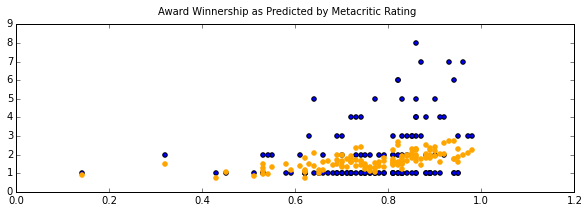

In [128]:
%matplotlib inline
plt.figure(figsize=(10,3)).suptitle('Award Winnership as Predicted by Metacritic Rating', fontsize='10')
plt.scatter(metarating, np.exp(y))
plt.scatter(metarating, np.exp(results.predict(X)), color='orange')
# get MSE
print('MSE for Multiplicative Exponential Model:   ' + str(MSE(results.predict(X), y)))

Again we see that this model does *ok* but isn't a perfect fit by any means. Notice that again the $BIC$ and $AIC$ values for this model are considerably lower than a typical linear equation.

###3.2.2: Additive Exponential Model for Oscar Wins

In [129]:
y = winners['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = np.exp(winners['UserRating'].as_matrix().tolist())
metarating = np.exp(winners['MetaRating'].as_matrix().tolist())
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     12.40
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           1.22e-05
Time:                        16:49:52   Log-Likelihood:                -229.06
No. Observations:                 128   AIC:                             464.1
Df Residuals:                     125   BIC:                             472.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.4021      2.023     -3.659      0.000       -11.406    -3.398
Meta-Slope     0.9189      0.555      1.656      0.100        -0.180     2.017
User-Slope     3.4627      1.100      3.149      0.002         1.286     5.639
==============================================================================
Omnibus:                       44.029   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.451
Skew:                           1.518   Prob(JB):                     2.78e-19
Kurtosis:                       5.609   Cond. No.                         55.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
print('MSE for Additive Exponential Model:   ' + str(MSE(results.predict(X), y)))

MSE for Additive Exponential Model:   2.09835757239


##3.3 Predicting Success amongst Nominees:

A similar analysis for movies that were only nominated, starting with the simple linear model and moving on to exponential models.

###3.3.1 Linear Model for Oscar Nominations

In [131]:
y = nominees['AwardsNominated'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = nominees['UserRating'].as_matrix().tolist()
metarating = nominees['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     6.972
Date:                Thu, 16 Jul 2015   Prob (F-statistic):            0.00126
Time:                        16:49:53   Log-Likelihood:                -310.03
No. Observations:                 159   AIC:                             626.1
Df Residuals:                     156   BIC:                             635.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.4203      1.432     -0.992      0.323        -4.249     1.408
Meta-Slope     2.6802      1.012      2.648      0.009         0.681     4.679
User-Slope     2.5212      2.183      1.155      0.250        -1.790     6.833
==============================================================================
Omnibus:                       74.626   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.614
Skew:                           1.876   Prob(JB):                     1.03e-54
Kurtosis:                       7.843   Cond. No.                         26.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
print('MSE for Simple Linear Model:   ' + str(MSE(results.predict(X), y)))

MSE for Simple Linear Model:   2.89195128656


###3.3.2 Additive Model for Oscar Nominations

In [133]:
y = winners['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = np.exp(winners['UserRating'].as_matrix().tolist())
metarating = np.exp(winners['MetaRating'].as_matrix().tolist())
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     12.40
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           1.22e-05
Time:                        16:49:53   Log-Likelihood:                -229.06
No. Observations:                 128   AIC:                             464.1
Df Residuals:                     125   BIC:                             472.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.4021      2.023     -3.659      0.000       -11.406    -3.398
Meta-Slope     0.9189      0.555      1.656      0.100        -0.180     2.017
User-Slope     3.4627      1.100      3.149      0.002         1.286     5.639
==============================================================================
Omnibus:                       44.029   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.451
Skew:                           1.518   Prob(JB):                     2.78e-19
Kurtosis:                       5.609   Cond. No.                         55.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
print('MSE for Additive Exponential Model:   ' + str(MSE(results.predict(X), y)))

MSE for Additive Exponential Model:   2.09835757239


###3.3.3 Multiplicative Exponential Model for Oscar Nominations

In [135]:

y = nominees['AwardsNominated'].as_matrix().tolist()
y = np.log(y)
x1 = [1 for _ in y] # constant
userrating = nominees['UserRating'].as_matrix().tolist()
metarating = nominees['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     7.754
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           0.000616
Time:                        16:49:54   Log-Likelihood:                -148.38
No. Observations:                 159   AIC:                             302.8
Df Residuals:                     156   BIC:                             312.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.9603      0.518     -1.854      0.066        -1.984     0.063
Meta-Slope     0.9185      0.366      2.509      0.013         0.195     1.642
User-Slope     1.2461      0.790      1.578      0.117        -0.314     2.806
==============================================================================
Omnibus:                       13.907   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.898
Skew:                           0.539   Prob(JB):                      0.00430
Kurtosis:                       2.304   Cond. No.                         26.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
print('MSE for Additive Exponential Model:   ' + str(MSE(results.predict(X), y)))

MSE for Additive Exponential Model:   0.378507614412


We see that none of the models perform particularly well here, with very small $R^2$ values across the board and little reason to trust use a model like this for predictive purposes

##3.4: Award Winnership as a Function of Many Variables:

What if there were data that explain some of the unaccounted-for variance in the previous models? Maybe other data (like Runtime, Budget, Opening Weekend Gross and Box Office Gross) can help account for why some movies win a lot of awards and others don't, despite similar critical reception. We repeat a process similar to the above

In [137]:
y = total['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = np.exp(total['UserRating'].as_matrix().tolist())
metarating = np.exp(total['MetaRating'].as_matrix().tolist())
budgets = total['Budget'].as_matrix().tolist()
opnwknd = total['OpeningWeekend'].as_matrix().tolist()
boxofcgrss = total['BoxOfficeGross'].as_matrix().tolist()
runtime = total['Runtime'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 
                       'User-Slope': userrating,
                       'Budget-Slope': budgets,
                       'Wknd-Slope': opnwknd,
                       'BOFFG-Slope': boxofcgrss,
                       'Runtime-Slope': runtime, 
                       'Intercept': x1
                      })
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     15.33
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           3.27e-15
Time:                        16:49:54   Log-Likelihood:                -531.81
No. Observations:                 290   AIC:                             1078.
Df Residuals:                     283   BIC:                             1103.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
BOFFG-Slope    2.925e-10   2.51e-10      1.167      0.244     -2.01e-10  7.86e-10
Budget-Slope   3.862e-08   2.16e-08      1.784      0.075     -3.98e-09  8.12e-08
Intercept        -7.6776      1.367     -5.615      0.000       -10.369    -4.986
Meta-Slope        1.8012      0.367      4.908      0.000         1.079     2.523
Runtime-Slope     0.0192      0.005      3.907      0.000         0.010     0.029
User-Slope        1.1492      0.813      1.414      0.158        -0.450     2.749
Wknd-Slope    -7.475e-09   5.36e-09     -1.393      0.165      -1.8e-08  3.08e-09
==============================================================================
Omnibus:                      147.114   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              756.434
Skew:                           2.102   Prob(JB):                    5.53e-165
Kurtosis:                       9.703   Cond. No.                     6.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [138]:
print('MSE for Additive Mixed Model:   ' + str(MSE(results.predict(X), y)))

MSE for Additive Mixed Model:   2.29277333698


# 4.1: Conclusions

Of all of these models, we see that the multiplicative exponential function performs the best. In fact, the model with the lowest $MSE$ was the multiplicative model of Awards Won against Review data:

$y = e^{\beta_0 + \beta_1 X_1+ \beta_2 X_2}$

The multi-variate extension of the additive model, while considerably more complex and less useful:

$y = \beta_0 + \beta_1 e^{X_1} + \beta_2 e^{X_2} +\beta_3 X_3 + \beta_4 X_4 + ...$

Also gets an honorable mention.

For some better intuition of what the first model means, lets look at what this surface looks like...

![OOO 3D](surface1.png) 
![OOO 3D](surface2.png) 
![OOO 3D](surface3.png) 
![OOO 3D](surface4.png) 


So maybe this *is* the best model overall: It predicts more oscar wins (amongst winners) for movies that have good metacritic scores and user ratings, not just one or the other. This reflects an intuition about how these awards work: they pick the best movie according to critics, with a smaller influence from public perception.

Regardless, this model is still fairly rudimentary when it comes to prediction. Despite a low $MSE$, good $AIC$ and $BIC$, and being generally feasible, it still accounts for less than half of the variation present in the data. Even the most complex model I dreamed up fails to account for a large amount of this variation: indicating that there are external factors that can cause certain movies to win many Academy Awards. These movies are indeed rare (e.g. Lord of the Rings: Return of the King or Titanic, both of which won 11 Oscars) and probably have a significant skewing effect on the data. 

Possibly there was some "hype" factor that caused these two movies to win more awards than they should have. Some critics suggested that part of the reason that the 3rd installment of LOTR won so many awards is that the previous movies weren't as heavily decorated and the academy wanted to "save" some awards for them when the franchise was complete. At any rate, the best conclusion we can draw from this data set is that there is some other factor out there that could help predict Oscar wins and that with the current data, we're only able to explain a shockingly low percentage of variation in the data. 

This shouldn't be too surprising: if a computer could predict who wins Oscars with some high degree of accuracy, film would be in a sad state of affairs.

# 5.1: Cross Validation and Testing for Stability

To judge the accuracy, stability and dependence on input data for this model, we use `scikit-learn`'s `cross_val_score` to implement k-fold crossvalidation. We test the simple mulitplicative exponential model:

$y = e^{\beta_0 + \beta_1 X_1+ \beta_2 X_2}$

In [140]:
y = winners['AwardsWon'].as_matrix().tolist()
y = np.log(y)
x1 = [1 for _ in y] # constant
userrating = winners['UserRating'].as_matrix().tolist()
metarating = winners['MetaRating'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 'User-Slope': userrating, 'Intercept': x1})

In [141]:
import sklearn
from sklearn import datasets, linear_model, cross_validation, grid_search
lr = linear_model.LinearRegression()
lr.fit(X, y)
kf_total = cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=1)
scores = cross_validation.cross_val_score(lr, X, y, cv=kf_total, n_jobs = 1)

In [142]:
print(scores)

[ 0.23390581 -0.79737168  0.20046389  0.52135145 -0.40226034  0.15006899
  0.11809217  0.24701021 -0.06923102  0.1768349 ]


In [143]:
print scores.mean(), scores.std()

0.0378864368449 0.358261108222


That is yet another nail in the coffin for the model: not only is it bad at predicting things, it's also highly unstable! 

Using a similar process for the larger-scale model:

In [144]:
y = total['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = np.exp(total['UserRating'].as_matrix().tolist())
metarating = np.exp(total['MetaRating'].as_matrix().tolist())
budgets = total['Budget'].as_matrix().tolist()
opnwknd = total['OpeningWeekend'].as_matrix().tolist()
boxofcgrss = total['BoxOfficeGross'].as_matrix().tolist()
runtime = total['Runtime'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 
                       'User-Slope': userrating,
                       'Budget-Slope': budgets,
                       'Wknd-Slope': opnwknd,
                       'BOFFG-Slope': boxofcgrss,
                       'Runtime-Slope': runtime, 
                       'Intercept': x1
                      })
lr = linear_model.LinearRegression()
lr.fit(X, y)
kf_total = cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=4)
scores_kfold = cross_validation.cross_val_score(lr, X, y, cv=kf_total, n_jobs = 1)
print scores

[ 0.23390581 -0.79737168  0.20046389  0.52135145 -0.40226034  0.15006899
  0.11809217  0.24701021 -0.06923102  0.1768349 ]


In [145]:
cv = cross_validation.ShuffleSplit(len(X), n_iter=10, test_size=0.3, random_state=1)
scores_shuffle = cross_validation.cross_val_score(lr, X, y, cv=cv, n_jobs = 1)
print(scores)

[ 0.23390581 -0.79737168  0.20046389  0.52135145 -0.40226034  0.15006899
  0.11809217  0.24701021 -0.06923102  0.1768349 ]


In [146]:
print scores_kfold.mean(), scores_kfold.std()
print scores_shuffle.mean(), scores_shuffle.std()

0.103264719215 0.198679054769
0.163031556245 0.104332807033


Again, all signs point to bad model. 

# 6.1: A Pruned Model

Although I'm usually not a fan of pruning data, but lets see how the modeling quest fares when we trim some of the extrema from the dataset - in particular, movies that have won 5 or more Oscars:

In [168]:
pruned = total[total['AwardsWon'] < 5]
total = pruned

In [169]:
print scores_kfold.mean(), scores_kfold.std()

0.0994715114119 0.188151625903


This still doesn't do much to solve the problem we see in the data: outliers are still messing up attempts at good prediction

In [172]:
y = total['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
userrating = total['UserRating'].as_matrix().tolist()
metarating = total['MetaRating'].as_matrix().tolist()
budgets = total['Budget'].as_matrix().tolist()
opnwknd = total['OpeningWeekend'].as_matrix().tolist()
boxofcgrss = total['BoxOfficeGross'].as_matrix().tolist()
runtime = total['Runtime'].as_matrix().tolist()
X = pd.DataFrame(data={'Meta-Slope': metarating, 
                       'User-Slope': userrating,
                       'Budget-Slope': budgets,
                       'BOFFG-Slope': boxofcgrss,
                       'Runtime-Slope': runtime, 
                       'Intercept': x1
                      })
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     9.956
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           9.41e-09
Time:                        16:55:03   Log-Likelihood:                -368.09
No. Observations:                 275   AIC:                             748.2
Df Residuals:                     269   BIC:                             769.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
BOFFG-Slope    3.288e-11   1.77e-10      0.186      0.852     -3.15e-10   3.8e-10
Budget-Slope   2.069e-08   1.31e-08      1.580      0.115      -5.1e-09  4.65e-08
Intercept        -3.1375      0.631     -4.972      0.000        -4.380    -1.895
Meta-Slope        1.4011      0.444      3.158      0.002         0.528     2.275
Runtime-Slope     0.0055      0.003      1.719      0.087        -0.001     0.012
User-Slope        2.7542      1.045      2.637      0.009         0.698     4.811
==============================================================================
Omnibus:                       51.171   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.565
Skew:                           1.169   Prob(JB):                     6.43e-17
Kurtosis:                       4.020   Cond. No.                     7.09e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [166]:
lr = linear_model.LinearRegression()
lr.fit(X, y)
kf_total = cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=4)
scores_kfold = cross_validation.cross_val_score(lr, X, y, cv=kf_total, n_jobs = 1)
print scores

[ 0.23390581 -0.79737168  0.20046389  0.52135145 -0.40226034  0.15006899
  0.11809217  0.24701021 -0.06923102  0.1768349 ]


In [167]:
print scores_kfold.mean(), scores_kfold.std()

0.0994715114119 0.188151625903
